# Working with EPA CEMS data

CEMS or <a href='https://www.epa.gov/emc/emc-continuous-emission-monitoring-systems'>**Continuous Emissions Monitoring Systems**</a> are used to track power plant's compliance with EPA emission standards. Included the data are hourly measurements of gross load, SO2, CO2, and NOx emissions associated with a given point source. The EPA's <a href='https://www.epa.gov/airmarkets'>Clean Air Markets Division</a> has collected CEMS data stretching back to 1995 and publicized it in their <a href='https://campd.epa.gov/'>data portal</a>. Combinging the CEMS data with geospatial, EIA and FERC data can enable greater and more specific analysis of utilities and their generation facilities. This notebook provides examples of working with the CEMS data in pudl.

***NOTE**: This Notebook presuposes access to the parquet files where the full CEMS data are stored.

#### Notebook Contents:
* **<a href='#setup'>Setup</a>**
* **<a href='#access'>Accessing CEMS data</a>**
 - <a href='#1subset'>1. Select a subset of raw data using Dask</a>
 - <a href='#2transfer'>2. Transfer desired data to pandas</a>
 - <a href='#3pickle'>3. Store custom CEMS dataframe as a pickle</a>
* **<a href='#manipulating'>Manipulating & Visualizing CEMS data</a>**
 - <a href='#emap'>1. Simple Choropleth</a>
 - <a href='#pcem'>2. Proportional Coordinates Map</a>
 - <a href='#glc'>3. State-to-State Gross Load Comparison</a>

<a id='setup'></a>
## Setup

The following kernels enable interaction with the CEMS dataset through pudl.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard libraries
import logging
import sys
import os
import pathlib

# 3rd party libraries
import geopandas as gpd
import dask.dataframe as dd
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy as sa

# Local libraries
import pudl

In [3]:
# Enable viewing of logging outputs
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

In [4]:
# Establish connection to pudl database
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine, freq='AS') #annual frequency

**The following settings and variables may be changed to impact the processing of this notebook**

In [5]:
# Display settings
sns.set()
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 100
pd.options.display.max_rows = 5

In [6]:
# CEMS dates
CEMS_year = 2018
CEMS_year_range = range(2010, 2012)

# State selection
state_subset = ['CO', 'TX', 'WY', 'MN', 'OH', 'PA', 'WV', 'FL', 'GE', 'CA']

<a id='access'></a>
## Accessing CEMS data

The CEMS dataset is enormous! It contains hourly emissions data on an hourly basis between 1995 and 2020, meaning that the full dataset is close to a billion rows and takes up 100 GB of space. That's a lot to process when you may only need a fraction of it for analysis. The following steps will help you access and work with CEMS efficiently.

<a id='1subset'></a>
### 1. Select a subset of raw data using Dask

Dask is a python package that parallelizes pandas dataframes so that you can access larger-than-memory data. With Dask, you can select the subset of CEMS data that you'd like to analyse *before* loading the data into a dataframe. While in Dask, you can interact with the data as if it were in a pandas dataframe. 

We'll start with a single year and offer an option to integrate a range of dates below.

In [7]:
# Locate the data for the given year/s on your hard drive.
epacems_path = (pudl_settings['parquet_dir'] + f'/epacems/year={CEMS_year}')

# Create a Dask object for preliminary data interaction
cems_dd = dd.read_parquet(epacems_path)

With a Dask dataframe you can learn things about the data such as column names and datatypes without having to load all of the data. If you take a look at the length of the Dask dataframe, you'll understand why we're not in pandas yet.

In [8]:
len(cems_dd) # This shows how many rows there are for one year!!

36768792

Take a look at the CEMS fields available below. The records are organized by the date and time of their measurement as well as the EIA plant id (`plant_id_eia`) and EPA unit id (`unitid`) they coorespond to. The EPA unit id is EPA's most granular level of emissions tracing; it represents a singular "smokestack" where emissions data are monitored and recorded. Depending on the unit in question, this unit may reflect a single generator (in the case of a combustion gas turbine where emissions are directly associated with generation), or a group of inter-operating biolers and generators (such as with steam powered generators where one or more boilers, possibly with differing fuel types, provide mechanical power to turbines). As a result, the EPA unit id *does not map directly onto EIA's generator id*, rather, it serves as its own unique grouping. 

The EPA is in the process of publishing a "crosswalk" spreadsheet that links EPA units to EIA's more granular boiler and generator ids. This information is forthcoming and will be integrated into pudl as soon as possible.

For more information on the individual fields, refer to the metadata.

In [9]:
cems_dd.columns.tolist()

['plant_id_eia',
 'unitid',
 'operating_datetime_utc',
 'operating_time_hours',
 'gross_load_mw',
 'steam_load_1000_lbs',
 'so2_mass_lbs',
 'so2_mass_measurement_code',
 'nox_rate_lbs_mmbtu',
 'nox_rate_measurement_code',
 'nox_mass_lbs',
 'nox_mass_measurement_code',
 'co2_mass_tons',
 'co2_mass_measurement_code',
 'heat_content_mmbtu',
 'facility_id',
 'unit_id_epa',
 'state']

Now that you know what's available, pick the columns you'd like to work with, and aggregate rows as necessary. Note that the `state` and `measurement_code` columns are categorical datatypes, meaning that they will overwhelm your computer memory if included in the list of columns you'd like to `groupby`. In pandas, this is solved by including the statement `observed=True` in the `groupby`, but with Dask we'll solve this by changing the datatype to string. As mentioned previously, the dataset is very large. If the Dask dataframe you construct is too similar to the original dataset -- imagine the example below without the `groupby` -- the client will be unable to load it in pandas and the kernel will attempt to run indefinitely (or until it crashes your computer). The dataset below should load in a couple of minutes when transfered to pandas.

In [10]:
# A list of the columns you'd like to include in your analysis
my_cols = [
    'state',
    'plant_id_eia', 
    'unitid',
    'so2_mass_lbs',
    'nox_mass_lbs',
    'co2_mass_tons'
]

# Select emissions data are grouped by state, plant_id and unit_id
# Remember to change the datatype for 'state' from category to string
my_cems_dd = (
    dd.read_parquet(epacems_path, columns=my_cols)
    .assign(state=lambda x: x['state'].astype('string'))
    .groupby(['plant_id_eia', 'unitid', 'state'])[
        ['so2_mass_lbs', 'nox_mass_lbs', 'co2_mass_tons']]
    .sum()
)

<a id='2transfer'></a>
### 2. Transfer desired data to pandas

Now that you've selected the data you want to work with, we'll transfer it to pandas so that all rows are accessible. It'll take a moment to run because there are so many rows. If it takes longer than a couple of minutes, check to see that your Dask dataset is altered enough from it's original form. Remember, it's in Dask because the data is bigger than your computer's memory! You'll have to do some grouping or paring down in order to access its entirety in pandas.

In [11]:
# Create a pandas dataframe out of your Dask dataframe and add a column to 
# indicate the year the data are coming from.
client = Client()
my_cems_df = (
    client.compute(my_cems_dd)
    .result()
    .assign(year=CEMS_year)
).reset_index()

In [12]:
my_cems_df

,plant_id_eia,unitid,state,so2_mass_lbs,nox_mass_lbs,co2_mass_tons,year
0,3,1,AL,4387.602051,33599.351562,27113.160156,2018
1,3,2,AL,4505.274902,33521.398438,27197.339844,2018
...,...,...,...,...,...,...,...
4384,57703,CT02,WY,469.441010,5892.234863,46481.609375,2018
4385,57703,CT03,WY,11.945000,337.455017,1182.767944,2018


To get data from *multiple* years, run the following code block. It's commented out because it takes a while to run and isn't required to run the full notebook.

In [13]:
# years = CEMS_years
# multi_year_cems_df = pd.DataFrame()

# for yr in years:
#     epacems_path = (pudl_settings['parquet_dir'] + f'/epacems/year={yr}')
#     cems_dd = (
#         dd.read_parquet(epacems_path, columns=my_cols)
#         .assign(state=lambda x: x['state'].astype('string'))
#         .groupby(['plant_id_eia', 'unitid', 'state'])[
#             ['so2_mass_lbs', 'nox_mass_lbs', 'co2_mass_tons']]
#         .sum())
#     cems_df = (
#         client.compute(cems_dd)
#         .result()
#         .assign(year=yr))
#     multi_year_cems_df = pd.concat([multi_year_cems_df, cems_df])

In [14]:
# multi_year_cems_df

<a id='3pickle'></a>
### 3. Store custom CEMS dataframe as a pickle

Because CEMS takes a while to run, it may be in your best interest to save your finalized CEMS dataframes as pickle files. This will prevent you from having to run the entire Dask-to-pandas process over and over if you restart the notebook and you want to access your carve-out of CEMS. Rather, it will save a local copy of your CEMS dataframe that it can access in a matter of seconds. Uncomment the following to set up a pickle file

In [15]:
# Savings CEMS as a pickle file
#path = os.getcwd()
#my_cems_df.to_pickle(path + '/MY_CEMS_DF.pkl')

In [16]:
# Accessing CEMS as a pickle file
#my_cems_df = pd.read_pickle(path + '/MY_CEMS_DF.pkl')
#my_cems_df

<a id='manipulating'></a>
## Manipulating & Visualizing CEMS data

Now that we have access to CEMS in pandas, lets see what we can do!

<a id='emap'></a>
### 1. Simple Choropleth
##### *Visualizing CEMS data*

Lets start by mapping which states have the highest CO2 emissions from power plants in 2018. States with darker colors will indicate higher CO2 emissions. To do this, we'll need to merge a geodataframe of the US with the desired emissions data from each state.

##### Prep US geospatial data:

In [17]:
# Use pre-existing pudl shapefile for state outlines
us_map_df = (
    pudl.analysis.service_territory.get_census2010_gdf(pudl_settings, 'state')
    .rename({'STUSPS10': 'state'}, axis=1)
    .to_crs("EPSG:3395") # Change the projection
)

We've already got the 2010 Census GeoDB.
Extracting the GeoDB into a GeoDataFrame


##### Prep CEMS data:

In [18]:
# Convert lbs to tons for so2 and nox and remove old columns
# Aggregate CEMS emissions data to the state level
cems_map_df = (
    my_cems_df.assign(
        so2_mass_tons=lambda x: x.so2_mass_lbs * 0.0005,
        nox_mass_tons=lambda x: x.nox_mass_lbs * 0.0005
    ).drop(columns=['so2_mass_lbs', 'nox_mass_lbs', 'plant_id_eia'], axis=1)
    .groupby(['state', 'year']).sum(min_count=1)
    .reset_index()
)

##### Combine with Geo-data and Plot:

In [19]:
# Combine CEMS and map dataframes
states_cems_gdf = pd.merge(us_map_df, cems_map_df, on='state', how='outer')

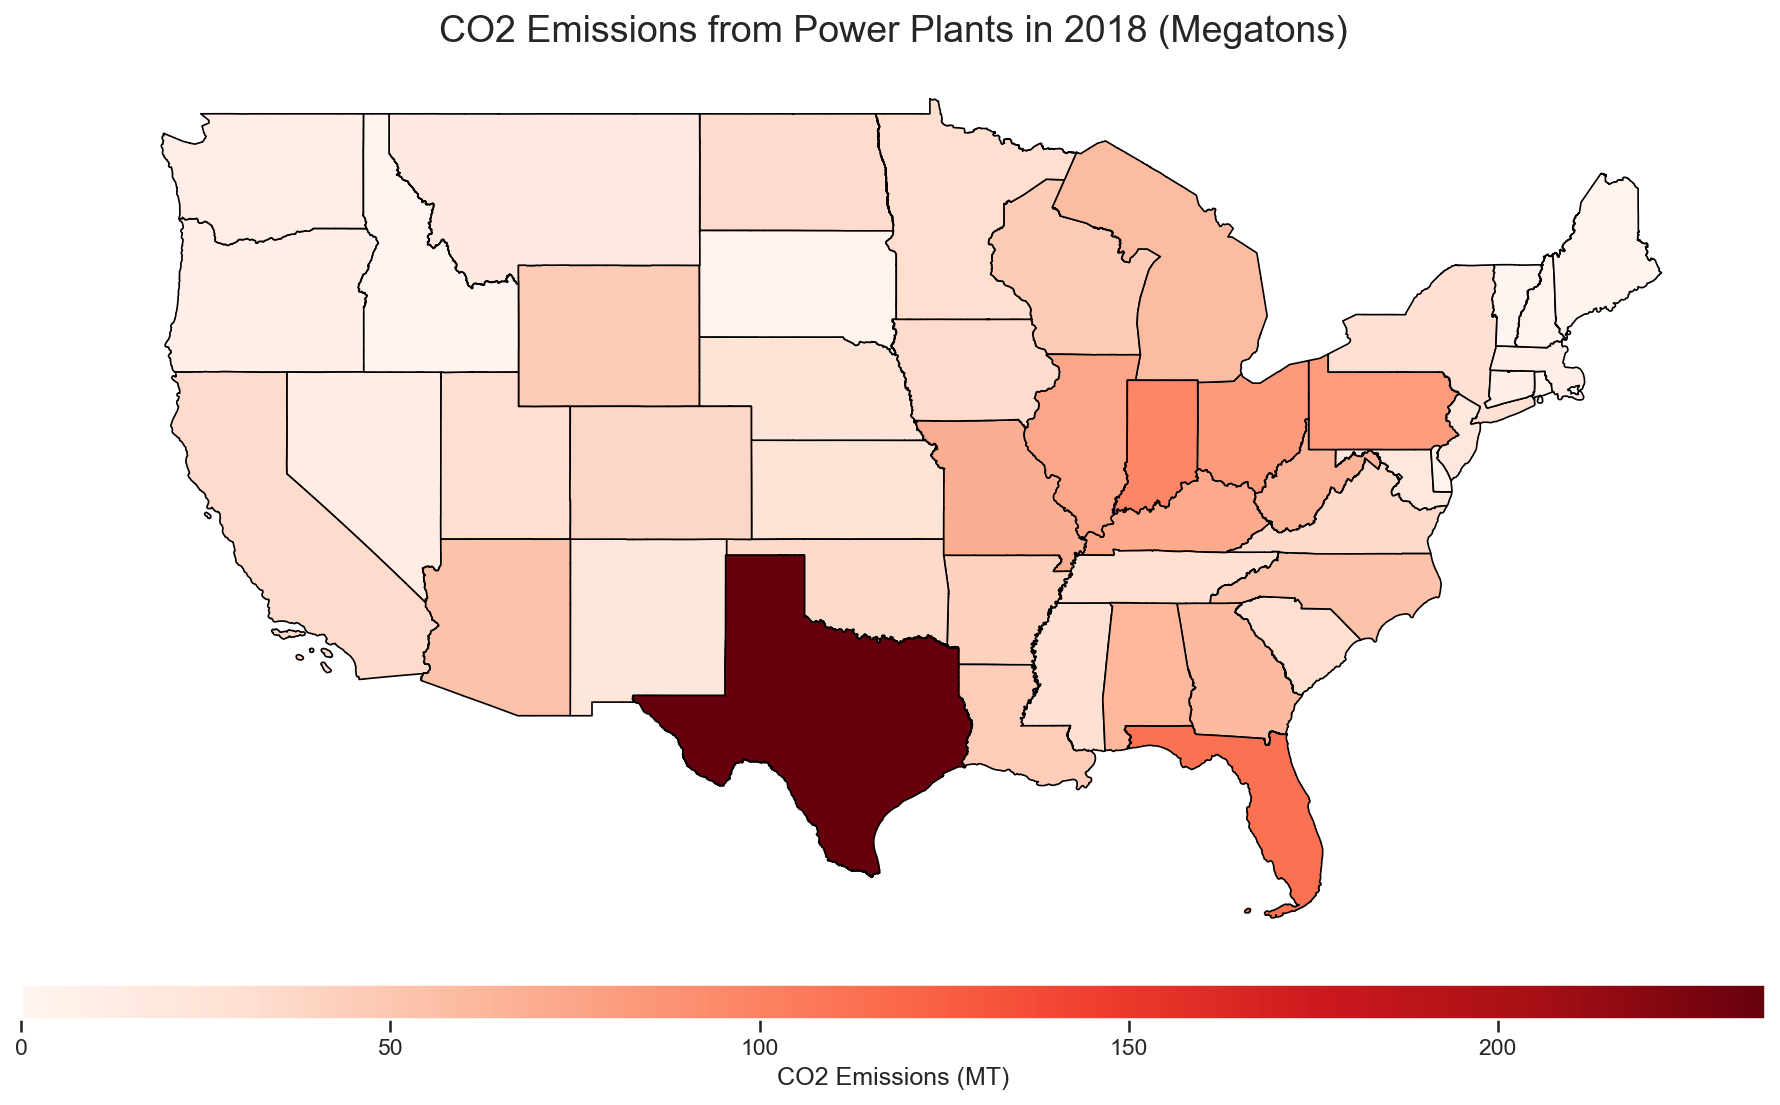

In [20]:
# Add plots for the US, HI, and AK

# The column on which to base the choroplath
choro_col = 'co2_mass_tons'

us_fig, us_ax = plt.subplots(figsize=(15, 10))
#ak_hi_fig, (ak_ax, hi_ax) = plt.subplots(ncols=2)

states_cems_gdf.plot(column=choro_col, cmap='Reds', linewidth=0.8, edgecolor='black', ax=us_ax)
#states_cems_gdf.plot(column=choro_col, cmap='Reds', linewidth=0.8, edgecolor='black', ax=ak_ax)
#states_cems_gdf.plot(column=choro_col, cmap='Reds', linewidth=0.8, edgecolor='black', ax=hi_ax)

us_ax.set_xlim(-1.45e7, -0.7e7) # Used to position US in center of the graph
us_ax.set_ylim(0.25e7, 0.65e7)  # Used to position US in center of the graph
us_ax.set_title('CO2 Emissions from Power Plants in 2018 (Megatons)', fontdict={'fontsize': '18'})
us_ax.axis('off')  # Remove lat and long tick marks
#ak_ax.set_xlim(1.9e7, 6.7e6)  #(-2e7, -1.4e7)
#ak_ax.set_ylim(0.6e7, 1.2e7)
#hi_ax.set_xlim(-1.71e7, -1.8e7)
#hi_ax.set_ylim(2e6, 2.6e6)

# Add a legend
vmax = states_cems_gdf[f'{choro_col}'].max() / 1000000 # (convert from tons to megatons)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=vmax))
sm._A = []
cbar = us_fig.colorbar(sm, orientation="horizontal", pad=0, aspect = 50, label='CO2 Emissions (MT)')

from matplotlib import axes
axes.Axes.mouseover

plt.show()

<a id='pcem'></a>
### 2. Proportional Coordinates Map
##### *Integrate CEMS emission quantities with EIA plant location data*

In order to integreate CEMS with other datasets in pudl, you'll need to start by integrating CEMS with a dataset that also has a field for `plant_id_eia`. If you want to integrate with FERC later on, you'll also want a dataset that has a field for `plant_id_pudl`. Integrating CEMS with EIA860 data will provide coordinates for each plant.

##### Prep CEMS data:

In [21]:
# Aggregate CEMS data to the plant level, adjust units for visualization purposes
cems_df = (
    my_cems_df
    .copy()
    .assign(
        co2_mass_mt=lambda df: df.co2_mass_tons / 10000 # measure in 10K tons
    ).drop(columns=['co2_mass_tons'], axis=1)
    .groupby(['plant_id_eia', 'state', 'year'])
    .sum(min_count=1)
    .reset_index()
)

##### Prep EIA data:

In [22]:
# Grab EIA 860 plant data that matched the year selected for CEMS
plants_eia860 = (
    pudl_out.plants_eia860()
    .assign(year=lambda df: df.report_date.dt.year)
    .query("year==@CEMS_year")
)

##### Combine EIA and CEMS data:

In [23]:
# Combine CEMS and EIA on plant_id_eia, state, and year
eia860_cems_df = (
    pd.merge(plants_eia860, cems_df, on=['plant_id_eia', 'state', 'year'], how='inner')
)

##### Overlay Coordinates on Base Map:

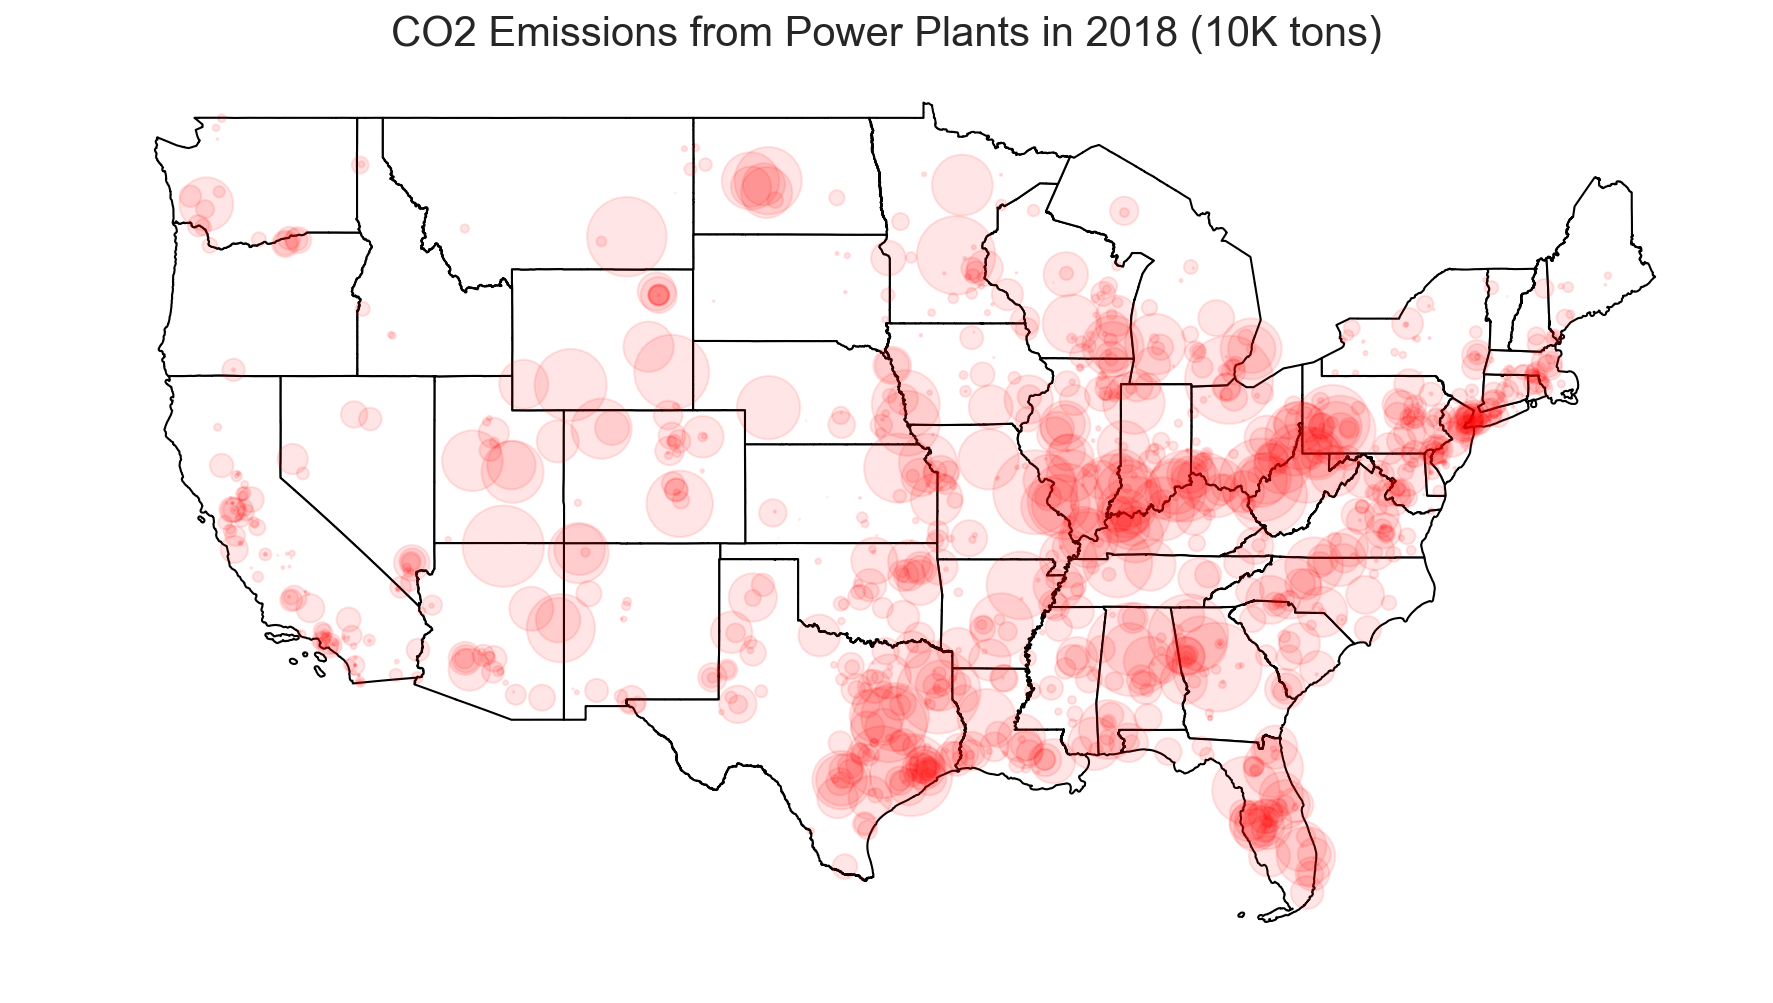

In [24]:
# Make lat and long data cols into plotable points in geopandas
# Make CRS compatile with base map
eia860_cems_gdf = (
    gpd.GeoDataFrame(
        eia860_cems_df, geometry=gpd.points_from_xy(
            eia860_cems_df.longitude, eia860_cems_df.latitude))
    .set_crs(epsg=4326, inplace=True) # necessary step before to_crs(epsg=3395)
    .to_crs(epsg=3395)
)

# Make a base map
us_fig, us_ax = plt.subplots(figsize=(15, 10))

base = us_map_df.plot(color='white', edgecolor='black', ax=us_ax)

us_ax.set_xlim(-1.45e7, -0.7e7) # Used to position US in center of the graph
us_ax.set_ylim(0.25e7, 0.65e7)  # Used to position US in center of the graph
us_ax.set_title('CO2 Emissions from Power Plants in 2018 (10K tons)', fontdict={'fontsize': '20'})
us_ax.axis('off')  # Remove lat and long tick marks

# Plot the coordinates on top of the base map
eia860_cems_df['alpha_co2'] = eia860_cems_df['co2_mass_mt'] 
eia860_cems_gdf.plot(ax=base, marker='o', color='red', markersize=eia860_cems_df['co2_mass_mt'], alpha=0.1)

plt.show()

<a id='glc'></a>
### 3. State-to-State Gross Load and Emissions Comparison
##### *Compare state load and emissions profiles*

Not all states use locally sourced electricity, however, looking at load profiles of plants in a given state can provide a glimpse of who is responsible for the greatest fossil peak load. This allocation can also be done by utility, but requires a table that maps plant or unit ownership percentage by utility.

##### Prep CEMS data (you'll have to re-load from Dask for this new data arrangement):

In [ ]:
year = 2018

# A list of the columns you'd like to include in your analysis
my_cols = [
    'state',
    'plant_id_eia', 
    'unitid',
    'operating_datetime_utc',
    'co2_mass_tons',
    'gross_load_mw',
]

my_cems_dd = (
    dd.read_parquet(epacems_path, columns=my_cols)
    .assign(
        state=lambda x: x['state'].astype('string'),
        month=lambda x: x['operating_datetime_utc'].dt.month)
    .groupby(['state', 'month'])['gross_load_mw', 'co2_mass_tons'].sum()
    .reset_index()
)

# Create a pandas dataframe out of your Dask dataframe and add a column to 
# indicate the year the data are coming from.
client = Client()
my_cems_gl = (
    client.compute(my_cems_dd)
    .result()
)

/Users/aesharpe/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/dask/dataframe/groupby.py:1766: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  g._meta = g._meta[key]
/Users/aesharpe/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55429 instead
  warnings.warn(


##### Select state subset:

In [ ]:
gl_piv = my_cems_gl.pivot(columns='state', index=['month'], values=['gross_load_mw'])
gl_piv_subset = gl_piv.iloc[:, gl_piv.columns.get_level_values(1).isin(state_subset)].copy()

co2_piv = my_cems_gl.pivot(columns='state', index=['month'], values=['co2_mass_tons'])
co2_piv_subset = co2_piv.iloc[:, co2_piv.columns.get_level_values(1).isin(state_subset)].copy()

##### Plot load and emissions comparison:

In [ ]:
fig, (gl_ax, co2_ax) = plt.subplots(1,2)

gl_piv_subset.plot(
    figsize=(15,8),
    xticks=gl_piv_subset.index,
    ylabel='Gross Load MW',
    xlabel='Months',
    ax=gl_ax
)

co2_piv_subset.plot(
    figsize=(15,8),
    xticks=gl_piv_subset.index,
    ylabel='Gross Load MW',
    xlabel='Months',
    ax=co2_ax
)

gl_ax.set_title('CEMS State-Level Gross Load 2018',fontsize= 18, pad=20)
co2_ax.set_title('CEMS State-Level CO2 Emissions 2018', fontsize=18, pad=20)

plt.show()

##### Plot CO2 to gross load comparison:

In [ ]:
# Add field for comparison
my_cems_gl['co2/load'] = my_cems_gl.co2_mass_tons / my_cems_gl.gross_load_mw

In [ ]:
# Pivot table around comparison field
gl_co2_piv = my_cems_gl.pivot(columns='state', index=['month'], values=['co2/load'])
gl_co2_piv_subset = gl_co2_piv.iloc[:, gl_co2_piv.columns.get_level_values(1).isin(state_subset)].copy()

In [ ]:
# Create a figure to plot the different values
fig, gl_co2_ax = plt.subplots()

gl_co2_piv_subset.plot(
    figsize=(15,8),
    xticks=gl_co2_piv_subset.index,
    xlabel='Months',
    ylabel='CO2 Emissions (Tons)',
    ax=gl_co2_ax
)

gl_co2_ax.set_title('State CO2 Emissions / Gross Load in 2018',fontsize= 18, pad=20)
plt.show()